In [1]:
# !apt-get install tree
# !pip install tensorflow-gpu==1.15.3

# import libs

In [1]:
import tensorflow as tf
#--------------------------------------
# print(tf.__version__)
# print(tf.config.list_physical_devices('GPU'))

/home/ai/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ai/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ai/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ai/anaconda3/envs/tf-gpu/lib/py

In [2]:
from tensorflow.compat.v1.keras import backend as K
config =  tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1/3
config.gpu_options.allow_growth = True
sess =  tf.compat.v1.Session(config=config)
K.set_session(sess)

In [3]:
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Dense, Conv2D, add, BatchNormalization, Dropout, Flatten, Reshape, LeakyReLU
from tensorflow.keras.models import Model 
import cv2
import numpy as np
import pandas as pd
# from tqdm import tqdm
import os
# from google.colab import drive
from PIL import Image
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt


# Data preparation

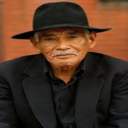

In [4]:
imgs_paths = glob("../UTKface/*.jpg")
im =Image.open(imgs_paths[1]).resize((128,128))
im

**Labels**<br>
The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

* [age] is an integer from 0 to 116, indicating the age
* [gender] is either 0 (male) or 1 (female)
* [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
* [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [5]:
# imgs_paths = glob(os.path.join('..', 'UTKface','*.jpg'))
# img_data = {'img_path':[], 'age':[], 'gender': [], 'race': []}
# for img in imgs_paths:
#   img_split = os.path.split(img)[-1].split('_')
#   if len (img_split) == 4 and img_split[0].isalnum() and img_split[1].isalnum() and img_split[2].isalnum():
#     img_data['img_path'].append(img)
#     img_data['age'].append(int(img_split[0]))
#     img_data['gender'].append(int(img_split[1]))
#     img_data['race'].append(int(img_split[2]))

# img_df = pd.DataFrame(img_data)
# # shuffle dataframe
# img_df = img_df.sample(frac=1).reset_index(drop=True)
# no_race_classes = len(img_df.race.unique())
# # mu = img_df['age'].mean()
# # sigma = img_df['age'].std()
# # img_df['age'] = (img_df['age']-mu)/sigma
# max_age = img_df['age'].max()
# img_df['age'] = img_df['age'] / max_age
# img_df.head()

In [6]:
# # split data
# w, h = 160, 160 
# msk = np.random.rand(len(img_df)) < 0.8
# train = img_df[msk].reset_index()
# valid = img_df[~msk].reset_index()
# print(len(train), len(valid))

In [7]:
max_age = 116
TRAINING_PATH = os.path.join('..', 'dataset', 'train.csv')
VALID_PATH = os.path.join('..', 'dataset', 'valid.csv')
train = pd.read_csv(TRAINING_PATH)
valid = pd.read_csv(VALID_PATH)
train.age = train.age * max_age
valid.age = valid.age * max_age
train.img_path = '../UTKface/'+ train.img_path
valid.img_path = '../UTKface/'+ valid.img_path
no_race_classes = train.race.unique().size
train.head()

,img_path,age,gender,race
0,../UTKface/41_0_0_20170117171015249.jpg,41.0,0,0
1,../UTKface/27_1_1_20170117013822716.jpg.chip.jpg,27.0,1,1
2,../UTKface/45_0_3_20170119201729135.jpg.chip.jpg,45.0,0,3
3,../UTKface/35_0_0_20170117191042138.jpg,35.0,0,0
4,../UTKface/23_0_1_20170114034248958.jpg.chip.jpg,23.0,0,1


Standard Scaler = (xi - mu)/ sigma

In [8]:
# mu = train.age.mean()
# sigma = train.age.std()
# train.age = (train.age - mu)/sigma
# valid.age = (valid.age - mu)/sigma

---

Robust Scaler = (xi - q1) / (q3 - q1)

In [9]:
q1, q3 = train.age.quantile([0.25,0.75]).to_list()
iqr = q3-q1
train.age = (train.age - q1)/iqr
valid.age = (valid.age - q1)/iqr

In [10]:
train.age.min(), train.age.max()

(-1.0, 4.2272727272727275)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ce8041438>,
      dtype=object)

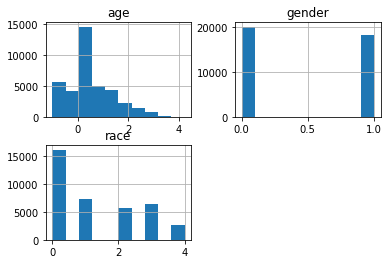

In [11]:
train.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c5c03e710>,
      dtype=object)

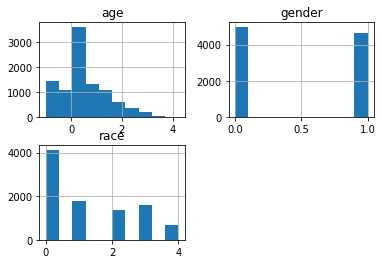

In [12]:
valid.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0be00b2b38>,
      dtype=object)

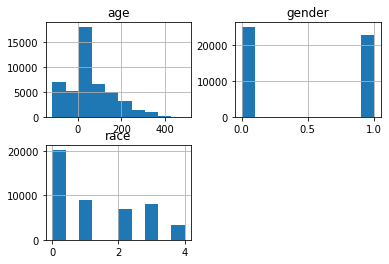

In [13]:
df = pd.concat((train, valid))
df.age = df.age * 116
df.hist()

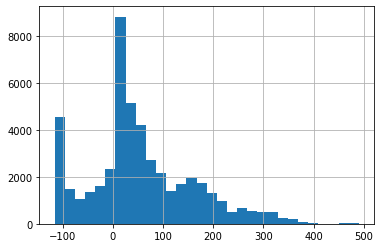

In [14]:
df.age.hist(bins=30)

## Data Generator

In [15]:
def gen(df, batch_size = 100, w=160, h=160):
  while True:
    samples_range = len(df)//batch_size
    for i in range(samples_range) :
      start = i * batch_size
      end = start + batch_size
      y = [
            np.array(df['age'].loc[start:end-1]), 
          ]
      x =[]
      for j in range (start, end):
        img = cv2.imread(df.loc[j]['img_path'],cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img =cv2.resize(img, (w,h) )
        x.append(img)
      x = np.array(x)/255.0
      yield x, y

In [16]:
g_train = gen(train, batch_size = 20)

In [17]:
x, y = next(g_train) 

In [18]:
x.shape

(20, 160, 160, 3)

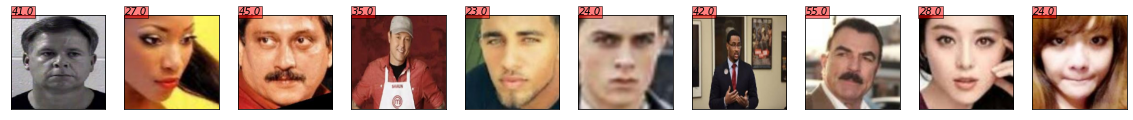

In [19]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(0, n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x[i])
    ax.text(0.95, 0.01, '{}'.format(np.round((y[0][i]*iqr+q1),3)), style='italic',
    bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 1})

    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Model3 : FaceNet + 3xFC

In [20]:
# https://drive.google.com/open?id=1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn
# https://drive.google.com/file/d/1PZ_6Zsy1Vb0s0JmjEmVd8FS99zoMCiN1/view?usp=sharing
# !gdown --id "1PZ_6Zsy1Vb0s0JmjEmVd8FS99zoMCiN1"

In [21]:
facenet = tf.keras.models.load_model('../pretrained_models/facenet_keras.h5')
# summarize input and output shape
print(facenet.inputs)
print(facenet.outputs)

[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/Identity:0' shape=(None, 128) dtype=float32>]


In [25]:
# freez pretrained layers
for i in range(len(facenet.layers)):
  facenet.layers[i].trainable = False

In [30]:
# build base model
img_input = facenet.input
base_model = facenet.output
base_model = tf.keras.layers.Dense(1024,activation='linear')(base_model)
#------------------------------- Age Model ----------------------------------------
age_base = tf.keras.layers.Dense(128,activation='relu')(base_model)
age_base = tf.keras.layers.Dropout(0.2)(age_base)
age_base = tf.keras.layers.BatchNormalization()(age_base)
age_base = tf.keras.layers.Dense(96,activation='relu')(age_base)
age_base = tf.keras.layers.Dropout(0.2)(age_base)
age_base = tf.keras.layers.BatchNormalization()(age_base)
age_base = tf.keras.layers.Dense(32,activation='relu')(age_base)
age_base = tf.keras.layers.Dropout(0.2)(age_base)
age_base = tf.keras.layers.BatchNormalization()(age_base)
age_base = tf.keras.layers.Dense(1,activation='linear',name='age_out')(age_base)
age_model = tf.keras.models.Model(img_input, age_base)
#---------------------------------------------------------------------

#---------------------------------------------------------------------
model = tf.keras.models.Model(inputs=[img_input], outputs=[age_base])
model.compile(optimizer='Adam', loss=['mae'])
# model.summary()

In [22]:
import datetime
RUN_NAME = 'age_only_model1'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('..','logs','models','{}.h5'.format(RUN_NAME)), 
                                                                      save_best_only=True, verbose=1) # 'model1.{epoch:02d}-{val_loss:.2f}.h5'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join('..','logs', 'fit'), histogram_freq=1)
# Create EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001, patience=50, restore_best_weights=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join('..','logs','csv_logger','{}.csv'.format(RUN_NAME)), separator=',', append=True)
callbacks = [early_stopping, tensorboard_callback, csv_logger, checkpoint]


In [23]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
# !mkdir models
# !rm -rf ./logs/

In [30]:
epoches = 100
batch_size = 64
steps_per_epoch = len(train)//batch_size
validation_steps = len(valid)//batch_size
train_set = gen(train, batch_size = batch_size)
valid_set = gen(valid, batch_size = batch_size)
hist = model.fit(train_set,steps_per_epoch=steps_per_epoch,
                  validation_data = valid_set, validation_steps = validation_steps,
                  epochs=epoches, shuffle=True, callbacks=callbacks, verbose=1)

Epoch 1/100
596/596 [==============================] - ETA: 0s - loss: 0.3614
Epoch 00001: val_loss did not improve from 0.36555
596/596 [==============================] - 244s 409ms/step - loss: 0.3614 - val_loss: 0.3701
Epoch 2/100
596/596 [==============================] - ETA: 0s - loss: 0.3610
Epoch 00002: val_loss did not improve from 0.36555
596/596 [==============================] - 244s 409ms/step - loss: 0.3610 - val_loss: 0.3787
Epoch 3/100
596/596 [==============================] - ETA: 0s - loss: 0.3595
Epoch 00003: val_loss did not improve from 0.36555
596/596 [==============================] - 246s 412ms/step - loss: 0.3595 - val_loss: 0.3671
Epoch 4/100
596/596 [==============================] - ETA: 0s - loss: 0.3595
Epoch 00004: val_loss did not improve from 0.36555
596/596 [==============================] - 245s 411ms/step - loss: 0.3595 - val_loss: 0.3710
Epoch 5/100
596/596 [==============================] - ETA: 0s - loss: 0.3593
Epoch 00005: val_loss did not impr

In [24]:
%tensorboard --logdir ../logs/fit

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
/home/ai/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ai/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ai/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = 

invalid info file: '/tmp/.tensorboard-info/pid-47813.info'
Traceback (most recent call last):
  File "/home/ai/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorboard/manager.py", line 316, in get_all
    info = _info_from_string(contents)
  File "/home/ai/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorboard/manager.py", line 155, in _info_from_string
    raise ValueError("incompatible version: %r" % (json_value,))
ValueError: incompatible version: {'cache_key': 'eyJhcmd1bWVudHMiOlsiLS1sb2dkaXIiLCIuLi9sb2dzL2ZpdCJdLCJjb25maWd1cmVfa3dhcmdzIjp7fSwid29ya2luZ19kaXJlY3RvcnkiOiIvaG9tZS9haS9Eb2N1bWVudHMvaGIvZmFjZXNfcHJvamVjdC9ub3RlYm9va3MifQ==', 'db': '', 'logdir': '../logs/fit', 'path_prefix': '', 'pid': 47813, 'port': 6006, 'start_time': 1594802700, 'version': '1.15.0'}
invalid info file: '/tmp/.tensorboard-info/pid-14185.info'
Traceback (most recent call last):
  File "/home/ai/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorboard/manager.py", line 316, in get_all
  

In [36]:
# from google.colab import files

uploaded = files.upload()
img_name = list(uploaded.keys())[0]
#-----------------------------------
img = cv2.imread(img_name,cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img =cv2.resize(img, (w,h) )/255.0
img = np.expand_dims(img, 0)
#--------------------------------------
pred = model.predict(img)
age = round((pred[0][0][0]*iqr)+q1)
gender =  int(np.round((pred[1][0][0]),0))
if gender == 0:
  gender = 'M'
else:
  gender = 'F'
race_idx = np.argmax(pred[1][0][0])
race_list = ['White', 'Black', 'Asian', 'Indian', 'Others']
race = race_list[idx]
#--------------------------------------
p_id=0
imshow(img[p_id])
pred = model3.predict([[img[p_id]]])
print(age, gender, race)

NameError: name 'files' is not defined

In [ ]:
%tensorboard --logdir logs/fit

In [31]:
batch_size=100
validation_steps = len(valid)//batch_size
valid_set = gen(valid)
model = tf.keras.models.load_model('../logs/models/{}.h5'.format(RUN_NAME))
valid_evaluation = model.evaluate(valid_set, steps=validation_steps, verbose=1 )

96/96 [==============================] - 45s 473ms/step - loss: 0.3656


In [28]:
valid_evaluation*iqr

11.421173214912415

In [ ]:
test_imgs = glob('../dataset/test_imgs/*')
x = []
for i in range(len(test_imgs)):
#     im =Image.open(test_imgs[i]).resize((160,160))
    im = cv2.resize(cv2.imread(test_imgs[i]), (160, 160))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    x.append(im)

x = np.array(x)/255.0
x.shape

In [ ]:
pred = model.predict(x)

In [ ]:
age = ((iqr*pred[0])+q1).astype('int')
gender = (pred[1]>0.5)*1
race = np.argmax(pred[2], axis=1).reshape(-1,1)
y = np.concatenate((age,gender,race), axis=1)

In [ ]:
n = len(test_imgs)  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(0, n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x[i])
    ax.text(0.95, 0.01, '{}, {}, {}'.format(y[i][0], y[i][1], y[i][2]), style='italic',
    bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 1})

    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()